In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import nltk

In [2]:
#common functions
%run functions.py

In [3]:
datos=pd.read_csv('train.csv')

In [4]:
datos.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
totalDatos = datos.shape[0]

# Veracidad de los tweets

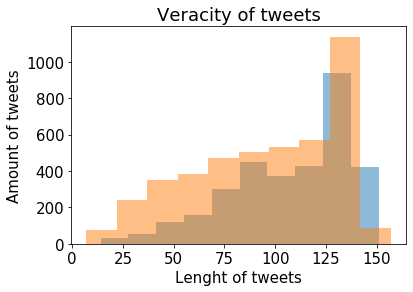

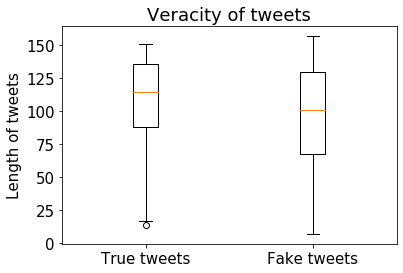

In [6]:
tweets = datos
tweets["size"] = tweets["text"].map(len)

true_tweets = tweets[tweets["target"] == 1]
fake_tweets = tweets[tweets["target"] == 0]

plt.rcParams.update({'font.size': 15})

#histogram
plt.hist(true_tweets["size"], 10, alpha=0.5, label='True tweets')
plt.hist(fake_tweets["size"], 10, alpha=0.5, label='Fake tweets')

plt.title("Veracity of tweets")
plt.xlabel("Lenght of tweets")
plt.ylabel("Amount of tweets")

#Boxplots
data_boxes = {'True tweets': true_tweets["size"], 'Fake tweets': fake_tweets["size"]}

fig, ax = plt.subplots()
bp = ax.boxplot(data_boxes.values())
ax.set_xticklabels(data_boxes.keys())
ax.set_title('Veracity of tweets')
ax.set_ylabel('Length of tweets')
plt.show()

# Análisis de los valores nulos por columna

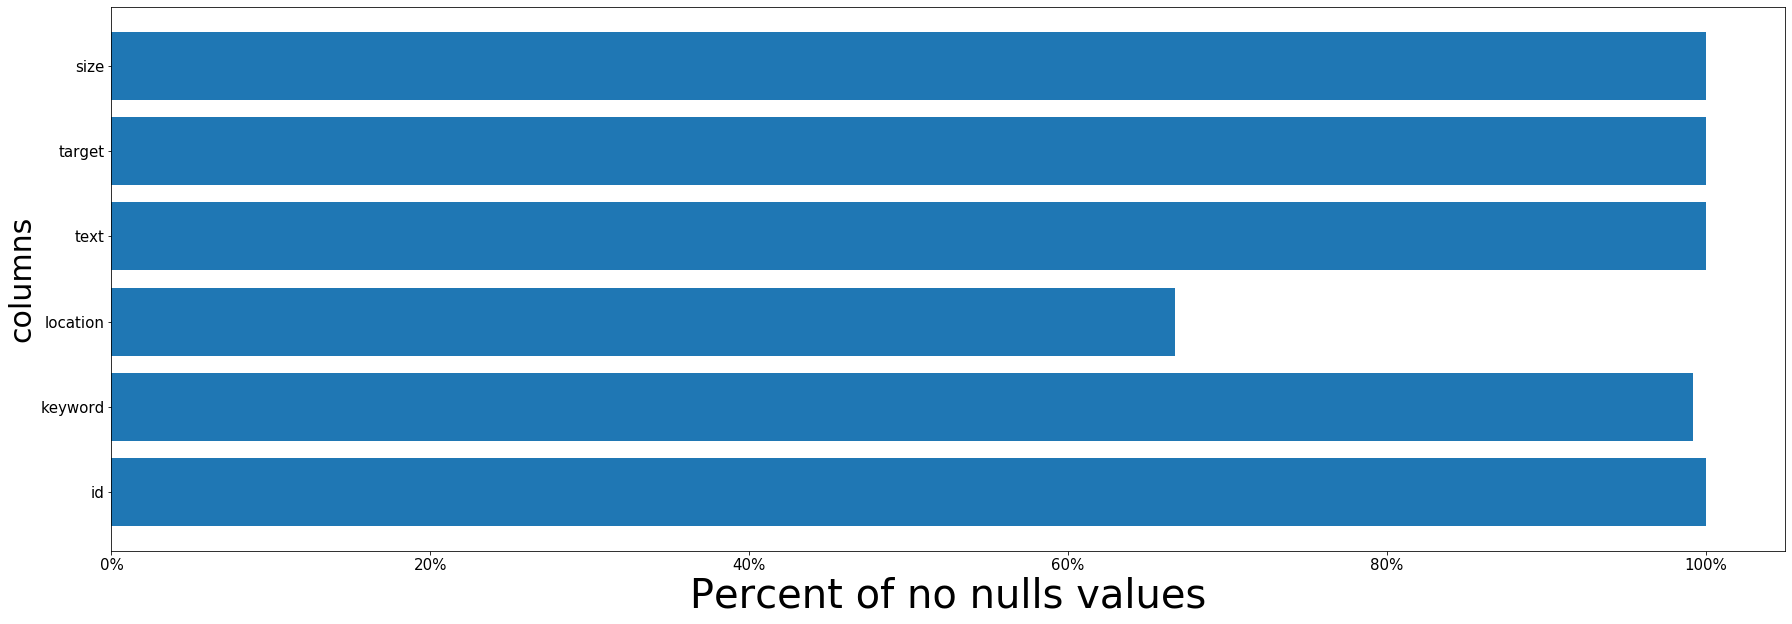

In [7]:
#Determinar el porcentaje de datos no nulos en cada columna para saber cuales tener en cuenta
nan_columns = []
nan_values = []

for column in datos.columns:
    nan_columns.append(column)
    nan_values.append(100*datos[column].notnull().sum()/datos.shape[0])

fig, ax = plt.subplots(figsize=(30,10))

plt.rcParams.update({'font.size': 60})

#format x axis in percentage
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
xticks = mtick.FormatStrFormatter(fmt)
ax.xaxis.set_major_formatter(xticks)

plt.xlabel("Percent of no nulls values", fontsize=40)
ax.set_ylabel('columns', fontsize=30)

plt.barh(nan_columns, nan_values);

# Qué porcentaje de tweets tienen links?

Text(0.5, 1.0, 'Porcentaje de tweets con links')

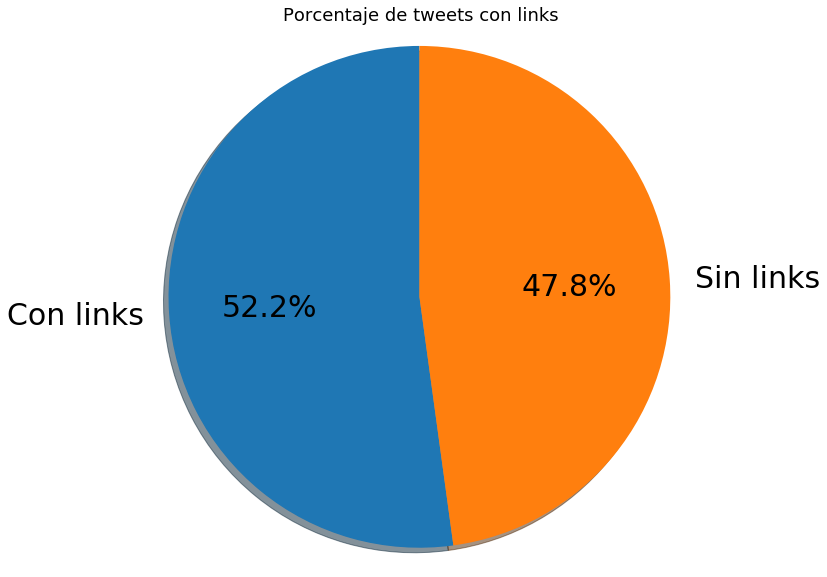

In [30]:
#Determina si una cadena contiene uno o mas links o no

#Se determina la cantidad de tweets que tienen links
datos["has_links"] = datos.apply(lambda row: hasLinks(row['text']), axis=1) 

porcentajeConLinks = 100*datos["has_links"].sum()/totalDatos
porcentajeSinLinks = 100 - porcentajeConLinks

labels = "Con links", "Sin links"
sizes = [porcentajeConLinks, porcentajeSinLinks]

fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, textprops ={"size":30} )
ax1.axis('equal');
ax1.set_title("Porcentaje de tweets con links")

# Análisis de los sitios más linkeados

Text(0.5, 1.0, 'Links de los tweets')

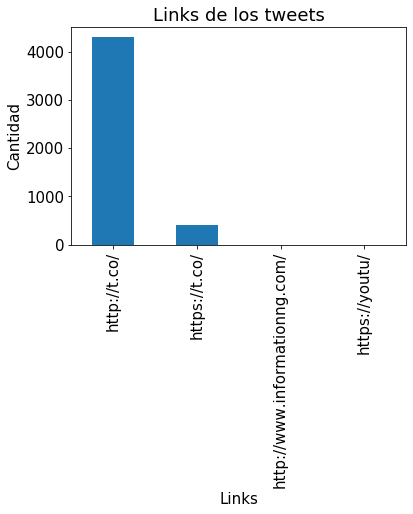

In [29]:
#Agregamos unicamente los links a los tweets que ya vimos que tienen links
datos["links"] = datos.apply(lambda row: getlinks(row['text']), axis=1)
links = datos.links.explode()
plt.rcParams['font.family'] = ['sans-serif']

plt.rcParams.update({'font.size': 15})

ax = links.value_counts().plot(kind="bar");
ax.set_xlabel("Links")
ax.set_ylabel("Cantidad")
ax.set_title("Links de los tweets")

In [10]:
#links.str.find("t.co")
#datos[datos.text.str.contains(":///")].text

Series([], Name: text, dtype: object)

# Palabras mas utilizadas en los tweets verdaderos

In [11]:
true_tweets = tweets[tweets["target"] == 1]
#print(true_tweets.count())

clean_true_tweets=true_tweets['text'].apply(limpiar_texto)
textototal = clean_true_tweets.values

textototal = " ".join(textototal)
textototal = re.sub(' +', ' ', textototal) #remove duplicated spaces

frecuencia_palabras = nltk.FreqDist(textototal.split(" "))
datos_frecuencia_palabras=frecuencia_palabras.most_common(30)

palabras=[]
cantidad=[]
for clave,valor in datos_frecuencia_palabras:
  palabras.append(clave)
  cantidad.append(valor)

In [12]:
palabras_tweets_verdaderos_con_cantidad=pd.DataFrame({"palabras":palabras,"cantidad":cantidad})

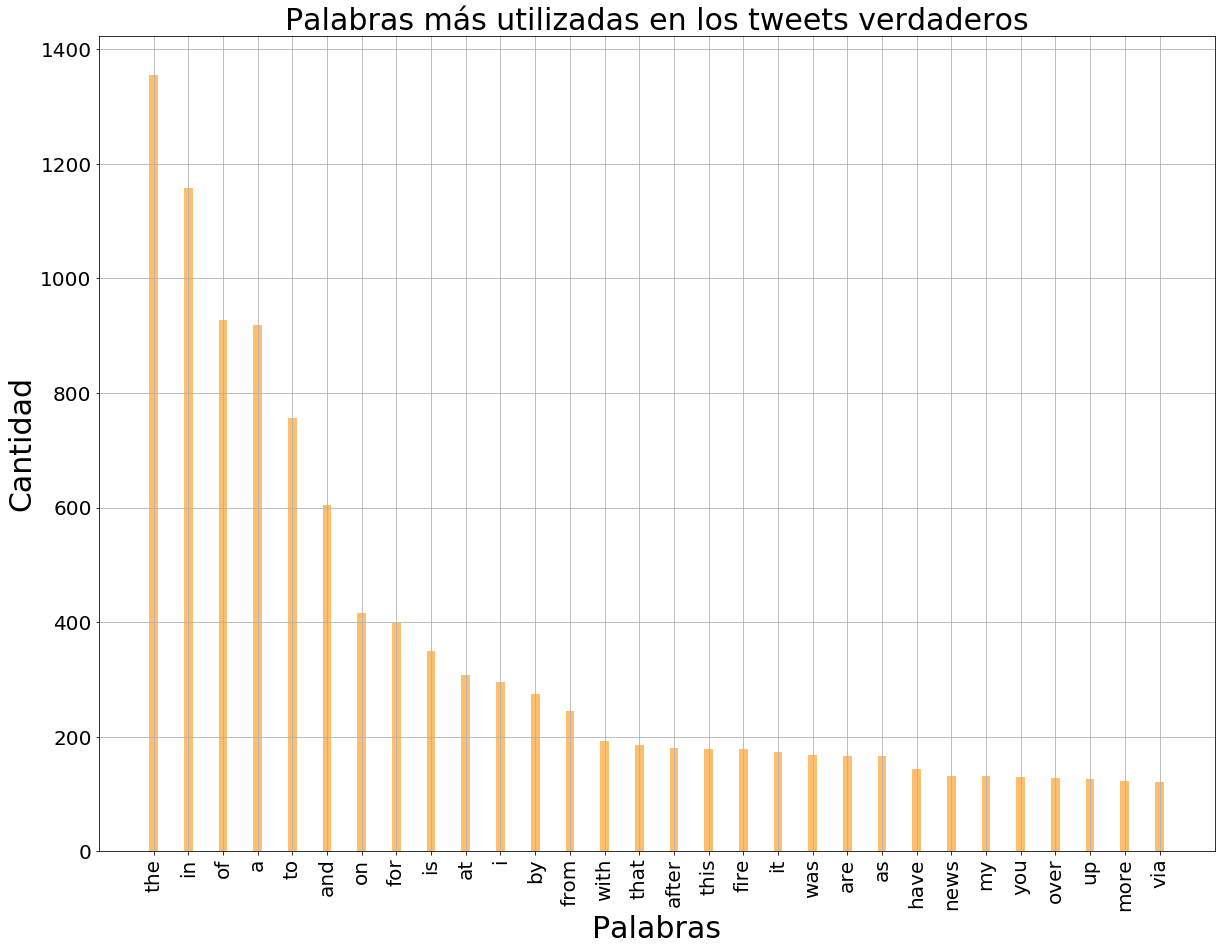

In [13]:
plt.figure(figsize=[20,15])
x=np.arange(len(palabras_tweets_verdaderos_con_cantidad['palabras']))
plt.bar(x,palabras_tweets_verdaderos_con_cantidad['cantidad'], width = 0.25,color=plt.cm.Paired(6))
plt.grid(True)
plt.xticks(np.arange(len(palabras_tweets_verdaderos_con_cantidad['cantidad'])),palabras_tweets_verdaderos_con_cantidad['palabras'],rotation='vertical',size=20) 
plt.yticks(size=20)
plt.title('Palabras más utilizadas en los tweets verdaderos',size=30)
plt.xlabel('Palabras',size=30)
plt.ylabel('Cantidad',size=30)
plt.show()

# Palabras más utilizadas en tweets falsos

In [14]:
fake_tweets = tweets[tweets["target"] == 0]
#print(fake_tweets.count())

clean_fake_tweets=fake_tweets['text'].apply(limpiar_texto)
textototal = clean_fake_tweets.values
textototal = " ".join(textototal)
textototal = re.sub(' +', ' ', textototal) #remove duplicated spaces

frecuencia_palabras = nltk.FreqDist(textototal.split(" "))
datos_frecuencia_palabras=frecuencia_palabras.most_common(30)

palabras=[]
cantidad=[]
for clave,valor in datos_frecuencia_palabras:
  palabras.append(clave)
  cantidad.append(valor)

In [15]:
palabras_tweets_falsos_con_cantidad=pd.DataFrame({"palabras":palabras,"cantidad":cantidad})

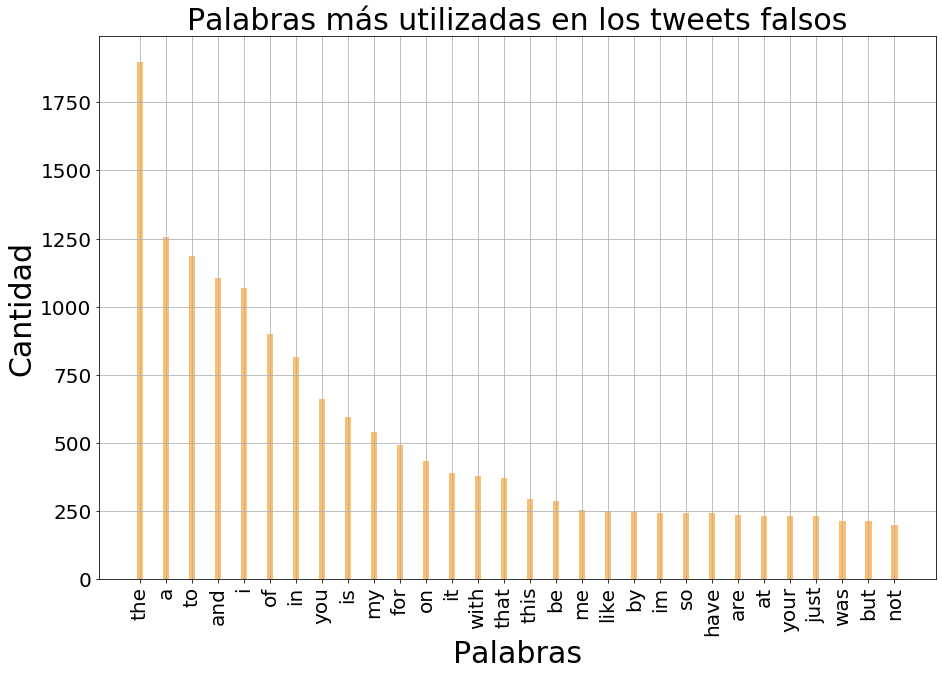

In [16]:
plt.figure(figsize=[15,10])
x=np.arange(len(palabras_tweets_falsos_con_cantidad['palabras']))
plt.bar(x,palabras_tweets_falsos_con_cantidad['cantidad'], width = 0.25,color=plt.cm.Paired(6))
plt.grid(True)
plt.xticks(np.arange(len(palabras_tweets_falsos_con_cantidad['cantidad'])),palabras_tweets_falsos_con_cantidad['palabras'],rotation='vertical',size=20) 
plt.yticks(size=20)
plt.title('Palabras más utilizadas en los tweets falsos',size=30)
plt.xlabel('Palabras',size=30)
plt.ylabel('Cantidad',size=30)
plt.show()

# Comparación entre las palabras más utilizadas en los tweets verdaderos o en los tweets falsos

In [17]:
#comparacion_palabras = palabras_tweets_falsos_con_cantidad.join(palabras_tweets_verdaderos_con_cantidad,how='outer',lsuffix='_falsos', rsuffix='_verdaderos')

In [18]:
comparacion_palabras = pd.merge(palabras_tweets_falsos_con_cantidad, palabras_tweets_verdaderos_con_cantidad, on='palabras', how='outer', indicator=True)
comparacion_palabras.head()

,palabras,cantidad_x,cantidad_y,_merge
0,the,1899.0,1356.0,both
1,a,1256.0,919.0,both
2,to,1187.0,757.0,both
3,and,1105.0,605.0,both
4,i,1069.0,296.0,both


In [19]:
first25cp = comparacion_palabras[:25] #.plot(kind="bar", rot=0);
first25cp

,palabras,cantidad_x,cantidad_y,_merge
0,the,1899.0,1356.0,both
1,a,1256.0,919.0,both
2,to,1187.0,757.0,both
3,and,1105.0,605.0,both
4,i,1069.0,296.0,both
5,of,900.0,927.0,both
6,in,815.0,1158.0,both
7,you,661.0,129.0,both
8,is,594.0,349.0,both
9,my,541.0,131.0,both


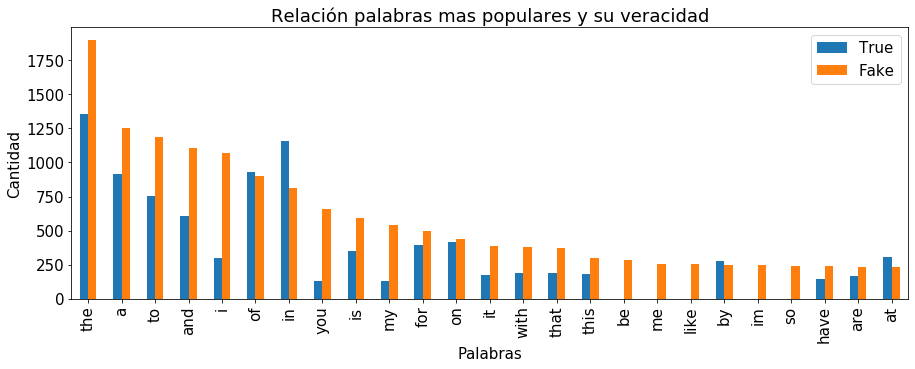

In [32]:
df = pd.DataFrame({ 'word':first25cp.palabras.array, 'Fake':first25cp.cantidad_x.array, 'True':first25cp.cantidad_y.array})
df = df[["word","True","Fake"]]
df.set_index(["word"],inplace=True)
ax = df.plot(kind='bar', figsize=(15,5), rot=90)
plt.xlabel("")
ax.set_xlabel("Palabras")
ax.set_ylabel("Cantidad")
ax.set_title("Relación palabras mas populares y su veracidad")
plt.show()